# Data Challenge : Historical consumption regression for electricity supply pricing

## Introduction

In this notebook, we present our work using XGBoost regressor for the prediction of electicity supply pricing. We begin with importing data and the pre-processing steps with the help of the module "model" that we created. Then we have applied our model for prediction and we compare results for training and validation. In the end we have fine tunned our model to enhance the mean absolute score and we used the "early stop" to avoid overfitting. 

### Importings

In [134]:
import numpy as np# linear algebra
import math
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.model_selection import RandomizedSearchCV

import xgboost 
from xgboost import plot_importance


from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt


# local import
from model import preprocessing

# 1. Data preparation

In [135]:
## Importing data

plt.style.use('fivethirtyeight')
#Import training data
inputFilePath = "./input_training_ssnsrY0.csv"
data_train = pd.read_csv(inputFilePath, delimiter = ',', skiprows = 0, index_col=[0])
id_train=data_train.timestamp

#Import testing data
inputFilePathTest = "./input_test_cdKcI0e.csv"
data_test = pd.read_csv(inputFilePathTest, delimiter = ',', skiprows = 0, index_col=[0])
id_test = data_test.index
# import targets
outputFilePath = "./output_training_Uf11I9I.csv"
y_data = pd.read_csv(outputFilePath, delimiter = ',', skiprows = 0, index_col=[0])

In [136]:
data=preprocessing.Data(data_train,data_test,y_data)
data.data_preprocessing()
X_train1,X_train2,X_test1,X_test2=data.get_data_split()
y_train1,y_train2=data.get_split_y_data()

C:\Users\youss\Desktop\docs_ml\time series\model\util\need.py:17: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = df.index.weekofyear


In [137]:
y_data=y_data.set_index(data_train.timestamp)

In [138]:
T1=y_train1.sum() # total consumption for site1
T2=y_train2.sum()

In [139]:
#Metric used for test
def wmae(y_actual, y_pred):
    return 2 * mean_absolute_error(y_actual*T1, y_pred*T2) / (T1+T2)

In [140]:
# validation data
X_val1 = X_train1.loc['2017-10-01':]
y_val1 = data.y_data['consumption_1'].loc['2017-10-01':]

X_val2 = X_train2.loc['2017-10-01':]
y_val2 = data.y_data['consumption_2'].loc['2017-10-01':]

# number of features
print(data.data_train.columns)

Index(['temp_1', 'temp_2', 'mean_national_temp', 'humidity_1', 'humidity_2',
       'consumption_secondary_1', 'consumption_secondary_2',
       'consumption_secondary_3', 'hour', 'month', 'year', 'dayofmonth',
       'quarter', 'weekofyear', 'dayofweek', 'temp_1_smooth7D',
       'temp_2_smooth7D', 'humidity_1_smooth7D', 'humidity_2_smooth7D'],
      dtype='object')


# 2. Model : XGBoost Regressor

In this section we will use the XGboost directly without fine tunning

In [142]:
# Initialisation of the model with the optimal parameters
xgb = xgboost.XGBRegressor()

In [143]:
## prediction for Lille (1)
eval_set = [(X_val1, y_val1)]
xgb.fit(X_train1, y_train1, eval_set=eval_set, verbose=0)
y_pred1 = xgb.predict(X_test1)
y_pred1_df = pd.DataFrame(y_pred1, index=data_test.index, columns=['pred1']) # save data in a DataFrame format

In [144]:
# Calculat the mean absolute error between training and prediction data
y_train_pred1 = xgb.predict(X_train1)
error1 = mae(y_train1, y_train_pred1) ## mse for the training
print("RMSE for training data: %f" % (error1))

RMSE for training data: 2.914056


In [145]:
## mae upon validation
y_pred_val= xgb.predict(X_val1)
error_val=mae(y_val1,y_pred_val)
print("mean absolute error for validation data: %f" % (error_val))

mean absolute error for validation data: 3.358819


Feature Importances :  [0.01059834 0.00759642 0.01149844 0.         0.00789002 0.
 0.06991258 0.01099913 0.01851565 0.07468703 0.7247399  0.00369746
 0.0064889  0.02925157 0.02412462]


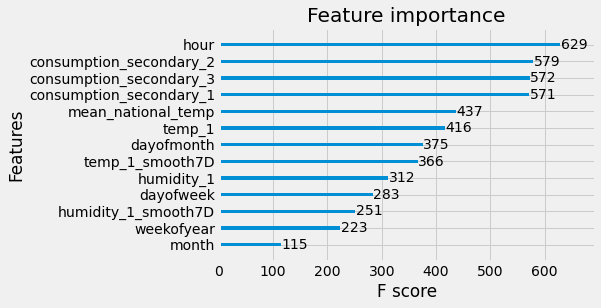

In [146]:
from xgboost import plot_importance
print("Feature Importances : ", xgb.feature_importances_)

# plot feature importance
plot_importance(xgb)
plt.show()

In [147]:
X_train1.columns

Index(['hour', 'dayofweek', 'month', 'year', 'dayofmonth', 'quarter',
       'weekofyear', 'mean_national_temp', 'consumption_secondary_1',
       'consumption_secondary_2', 'consumption_secondary_3', 'temp_1',
       'humidity_1', 'temp_1_smooth7D', 'humidity_1_smooth7D'],
      dtype='object')

In [148]:
# We will update out training data by selecting the importants features 
important_features=['hour', 'dayofweek', 'month',  'dayofmonth', 
       'weekofyear', 'mean_national_temp', 'consumption_secondary_1',
       'consumption_secondary_2', 'consumption_secondary_3', 'temp_1',
       'humidity_1', 'temp_1_smooth7D', 'humidity_1_smooth7D']
X_train11 = X_train1[important_features]
xgb.fit(X_train11, y_train1)

# Calculat the mean absolute error between training and prediction data
y_train_pred1 = xgb.predict(X_train11)
error1 = mae(y_train1, y_train_pred1) ## mse for the training
print("mae for training data after removing non important features: %f" % (error1))


mae for training data after removing non important features: 2.914056


* The impact of removing non important features is very small

In [149]:
X_val11 = X_train11.loc['2017-10-01':]
y_pred_val= xgb.predict(X_val11)
error_val=mae(y_val1,y_pred_val)
print("mae for validation data : %f" % (error_val))

mae for validation data : 3.358819


In [150]:
#X_train13 = X_train12.drop(['weekofyear'], axis=1)
xgb.fit(X_train11, y_train1)

# Calculat the mean absolute error between training and prediction data
y_train_pred1 = xgb.predict(X_train11)
error1 = mae(y_train1, y_train_pred1) ## mse for the training
print("RMSE for training data: %f" % (error1))
### results 0.052

RMSE for training data: 2.914056


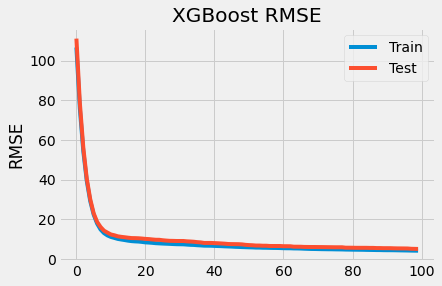

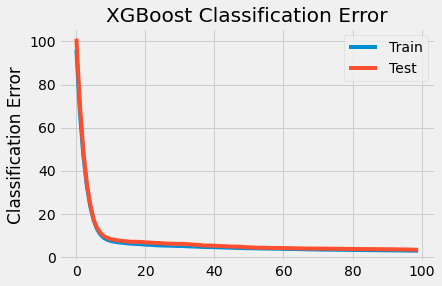

In [151]:
# fit model no training data
model = xgboost.XGBRegressor()
eval_set = [(X_train1, y_train1), (X_val1, y_val1)]
model.fit(X_train1, y_train1,early_stopping_rounds=50, eval_metric=["mae", "rmse"], eval_set=eval_set, verbose=0)
# make predictions for test data
y_pred = model.predict(X_test1)
predictions = [round(value) for value in y_pred]
# evaluate predictions
#accuracy = accuracy_score(y_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

* we have used early stopping to avoid overfitting
* we dont dispose of testing target so we can't use in next prediction 
* Instead we will avoid overfitting by reducing the number of iteration to around 35 in next models

#### For the second location 2

In [152]:
## prediction for Aix (2)
xgb.fit(X_train2, y_train2)
y_pred2 = xgb.predict(X_test2)
y_pred2_df = pd.DataFrame(y_pred2, index=data_test.index, columns=['pred2'])

In [153]:
y_train_pred2 = xgb.predict(X_train2)
error2= mae(y_train2, y_train_pred2) ## mse for the training
print("RMSE for training Data: %f" % (error2))

## mae upon validation
y_pred_val2= xgb.predict(X_val2)
error_val2=mae(y_val2,y_pred_val2)
print("mean absolute error for validation data: %f" % (error_val2))

RMSE for training Data: 3.077570
mean absolute error for validation data: 3.165013


Feature Importances :  [0.01937107 0.00362437 0.35617816 0.         0.01053394 0.
 0.08633156 0.00411069 0.01104823 0.24504006 0.13015862 0.01019175
 0.00241687 0.05736195 0.06363283]


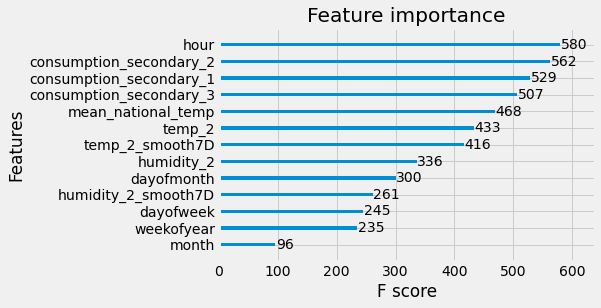

In [154]:
print("Feature Importances : ", xgb.feature_importances_)

# plot feature importance
plot_importance(xgb)
plt.show()

In [155]:
# We will update out training data by selecting the importants features 
important_features=['hour', 'dayofweek', 'month',  'dayofmonth', 
       'weekofyear', 'mean_national_temp', 'consumption_secondary_2',
       'consumption_secondary_1', 'consumption_secondary_3', 'temp_2',
       'humidity_2', 'temp_2_smooth7D', 'humidity_2_smooth7D']
X_train22=X_train2[important_features]
xgb.fit(X_train22, y_train2)
y_train_pred2 = xgb.predict(X_train22)
error2= mae(y_train2, y_train_pred2) ## mse for the training
print("RMSE for training Data: %f" % (error2))

## mae upon validation
X_val22=X_val2[important_features]
y_pred_val2= xgb.predict(X_val22)
error_val2=mae(y_val2,y_pred_val2)
print("mean absolute error for validation data: %f" % (error_val2))
## we notice that the mse remains the same

RMSE for training Data: 3.077570
mean absolute error for validation data: 3.165013


In [156]:
## Erreur pour les deux sites
error= (error1*T1+ error2*T2)/(T1+T2)
print("WMAE : the  metric used in the challenge: %f" % (error))

WMAE : the  metric used in the challenge: 2.998951


In [157]:
## create the submission csv file
sub2 = pd.concat([y_pred1_df, y_pred2_df], axis=1).set_index(id_test)
sub2.to_csv('submission_xgb.csv')

* resulting accuracy in the data challenge 19.45

# 3. Parameter tunning for XGBoost

For localisation 1

In [158]:
## Hyper Parameter Optimization

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "n_estimators"     : range(50,300,50),
 "max_depth"        : [ 2,3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 'metric': ['l2', 'auc']}

# We have used random search instead of grid search to optimise calculating time 
random_search=RandomizedSearchCV(xgb,
                                param_distributions=params,
                               n_iter=5,                           
                               n_jobs=-1, 
                               cv=5,
                               random_state=1)


In [159]:
random_search.fit(X_train1, y_train1)
random_search.best_params_

[01:55:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




{'n_estimators': 150,
 'min_child_weight': 5,
 'metric': 'auc',
 'max_depth': 5,
 'learning_rate': 0.15,
 'gamma': 0.2,
 'colsample_bytree': 0.3}

* we take the tunned parameters and we set the n_estimators to 25 so as to avoid oferfitting


In [160]:
params={'n_estimators': 35,
 'min_child_weight': 1,
 'metric': 'l2',
 'max_depth': 10,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'colsample_bytree': 0.7}
xgb = xgboost.XGBRegressor(**params)

In [161]:
## prediction for Lille (1)
eval_set = [(X_train1, y_train1), (X_val1, y_val1)]
xgb.fit(X_train1, y_train1, verbose=0)
y_pred1 = xgb.predict(X_test1)
y_pred1_df = pd.DataFrame(y_pred1, index=data_test.index, columns=['pred1'])

# the metric used to evaluate the model upon training data
xgb.fit(X_train1, y_train1, verbose=0)
pred1_train = xgb.predict(X_train1)
rmse = np.sqrt(mean_squared_error(y_train1, pred1_train)) ## mse for the training
print("RMSE for training Data:", (rmse))
### for validation
## mae upon validation
y_pred_val= xgb.predict(X_val1)
error_val=mae(y_val1,y_pred_val)
print("mean absolute error for validation data:",error_val)
### test prediction
pred1 = xgb.predict(X_test1)
pred1_df = pd.DataFrame(pred1,index=X_test2.index, columns=['pred1'])

[01:55:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:55:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


RMSE for training Data: 7.081687759917087
mean absolute error for validation data: 5.228319472754562


<AxesSubplot:xlabel='timestamp'>

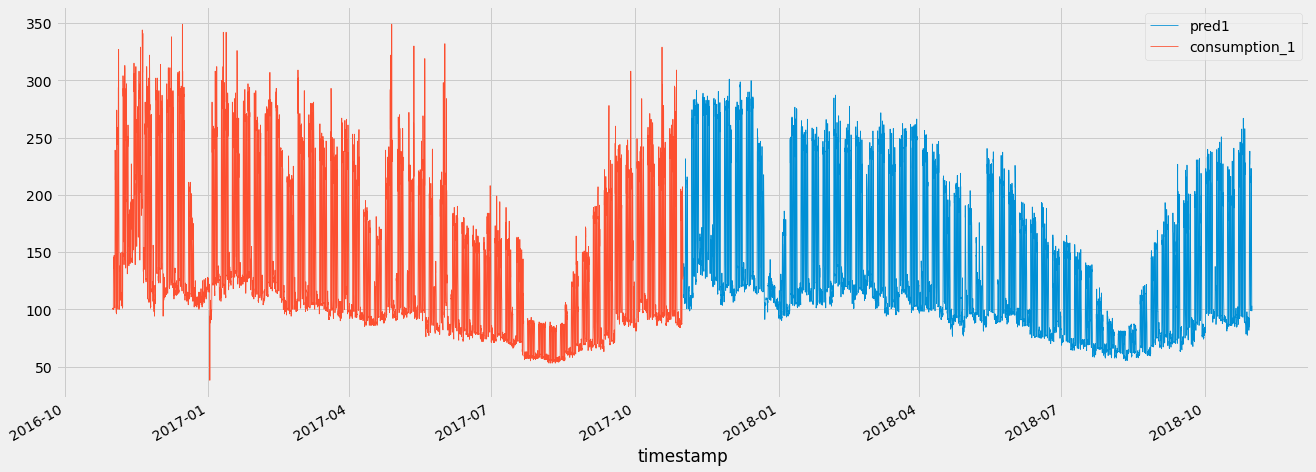

In [162]:
pred1_df.plot(figsize=(20,8), lw=0.8, legend=True)
y_train1.plot(figsize=(20,8), lw=0.8, legend=True)

For localisation 2

In [163]:
random_search.fit(X_train2, y_train2)
random_search.best_params_

[01:56:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




{'n_estimators': 150,
 'min_child_weight': 5,
 'metric': 'l2',
 'max_depth': 12,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'colsample_bytree': 0.4}

In [164]:
param={'n_estimators': 30,
 'min_child_weight': 1,
 'metric': 'l2',
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'colsample_bytree': 0.7}
xgb = xgboost.XGBRegressor(**param)

In [165]:
## prediction for Aix (2)
xgb.fit(X_train2, y_train2)
y_pred2 = xgb.predict(X_test2)
y_pred2_df = pd.DataFrame(y_pred2, index=data_test.index, columns=['pred2'])
# the metric used to evaluate the model upon training data
pred2 = xgb.predict(X_train2)
rmse = mae(y_train2, pred2) ## mse for the training
print("RMSE for training Data: %f" % (rmse))
### test prediction
pred2 = xgb.predict(X_test2)
pred2_df = pd.DataFrame(pred2, index=X_test1.index, columns=['pred2'])
##

[01:56:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


RMSE for training Data: 7.985795


<AxesSubplot:xlabel='timestamp'>

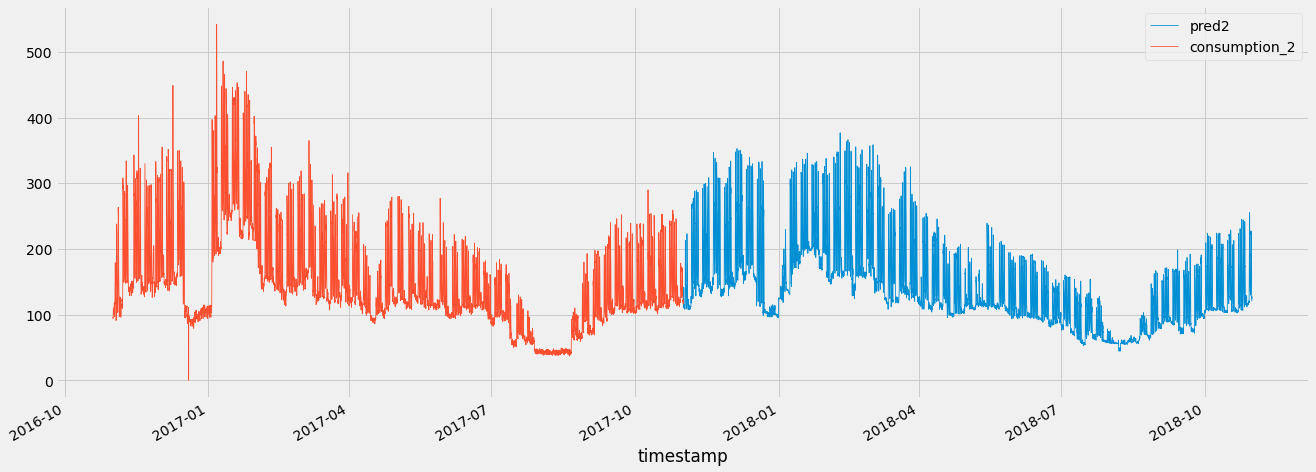

In [166]:
pred2_df.plot(figsize=(20,8), lw=0.8, legend=True)
y_train2.plot(figsize=(20,8), lw=0.8, legend=True)

In [167]:
sub3 = pd.concat([pred1_df, pred2_df], axis=1).set_index(id_test)
sub3.to_csv('submission_xgb_2.csv')

* Resulting accuracy in the data challenge 18.45 
* Ranking 31/90